# 3D

In [1]:
import sys
sys.path.append('../')

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from ELD.utils import circle_size, colors, toImg, preprocess
from ELD.model import loadFan#, predict_landmarks
from torchgeometry.contrib import spatial_soft_argmax2d
from glob import glob
import tifffile as tiff

In [4]:
def load_imgs(path):
    #get files with glob
    files = glob(f"{path}*")
    #sort files by number
    files = sorted(files, key=lambda x: int(x.split('/')[-1].split('.')[0]))
    #load images
    if files[0].endswith('.tif'):
        imgs = [tiff.imread(f) for f in files]
    else:
        imgs = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in files]
    return imgs


In [5]:
#You can download the dataset from here: https://figshare.com/projects/ELD/167318

In [7]:
#set your path here
#PATH = "../../marcoAnalysis/"
PATH = "/data/ekvall/marcoAnalysis/"

## CODA prostate

In [8]:
inpath = f'{PATH}CODA_prostate/'

In [9]:
#load imgs and move to tensor
mob_he = load_imgs(inpath)
image = torch.stack([preprocess(img) for img in mob_he])


You can can either train a model with:

```
python train.py --elastic_sigma 3.5 --cuda 0 --port 9100 --data_path ../marcoAnalysis/CODA_prostate/ --npts 20 --o scratch --ws 10_000 --angle 10 --model 3d
```

Or download a test model at: https://figshare.com/projects/ELD/167318


In [10]:
#load model
fan = loadFan(npoints=20,n_channels=3,path_to_model="../models/3d/mouse_prostate/model_111.fan.pth")

In [11]:
def predict_landmarks(fan, image):
    with torch.no_grad():
        #img = sample['Im']
        
        fan.eval()

        with torch.no_grad():
            pts = 4 * spatial_soft_argmax2d(fan(image.cuda()), False)
    return pts
        

In [12]:
#predict landmarks
pts = predict_landmarks(fan, image)
#combine landmarks and image
np_img = toImg(image.cuda()[:,:3], pts, 128)


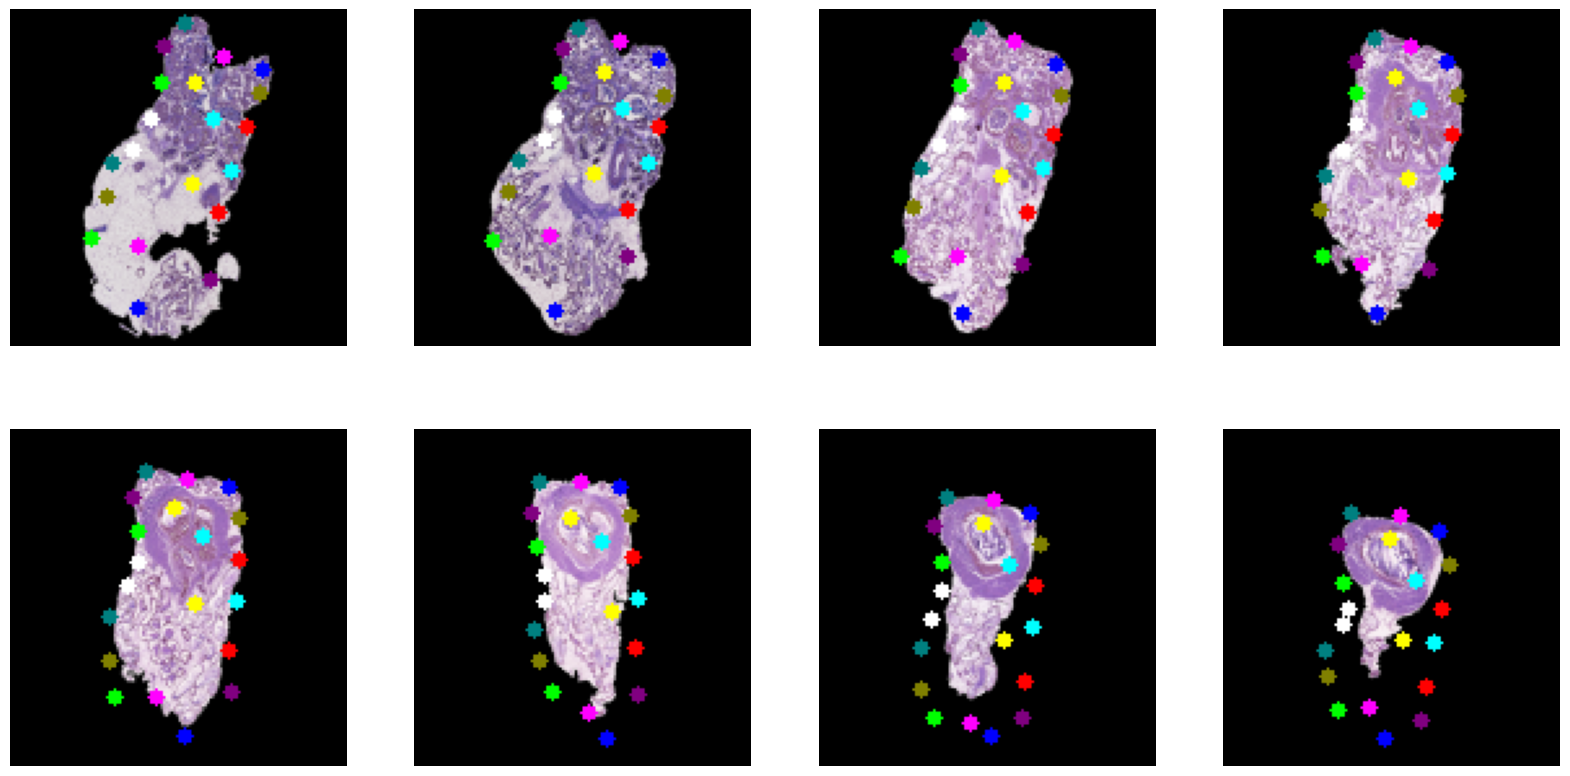

In [13]:
len(np_img)

#pick 8 images uniformly for 0..260
idx = np.linspace(0,259,8).astype(int)
#plot images

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(np_img[idx[i]])
    ax.axis('off')